# Using the 10% Subset data


Although, the proposed data set still suffers from some
of the problems discussed by McHugh [4] and may not be
a perfect representative of existing real networks, because
of the lack of public data sets for network-based IDSs, we
believe it still can be applied as an effective benchmark data
set to help researchers compare different intrusion detection
methods.

- source: A Detailed Analysis of the KDD CUP 99 Data Set 
- Mahbod Tavallaee, Ebrahim Bagheri, Wei Lu, and Ali A. Ghorbani


In [1]:
import tensorflow as tf
import sys
import sklearn as sk
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as pltLib
import sklearn.feature_extraction.text as sk_text
from scipy.stats import zscore

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
import io
import requests
from sklearn import metrics

# Useful Functions for Pre-processing data used for Tensorflow

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

In [3]:
data_path = './data/'

In [4]:
df = pd.read_csv(os.path.join(data_path, "network_intrusion_data.csv"))

In [5]:
pd.set_option('max_columns', None)

In [6]:
df

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,0.5,1,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,8,8.1,0.00,0.00.1,0.00.2,0.00.3,1.00,0.00.4,0.00.5,9,9.1,1.00.1,0.00.6,0.11.1,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
0,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


Adding column headers

In [7]:
df.columns = [ 
    'duration', 
    'protocol_type', 
    'service', 
    'flag', 
    'src_bytes', 
    'dst_bytes', 
    'land', 
    'wrong_fragment', 
    'urgent', 
    'hot', 
    'num_failed_logins', 
    'logged_in', 
    'num_compromised', 
    'root_shell', 
    'su_attempted', 
    'num_root', 
    'num_file_creations', 
    'num_shells', 
    'num_access_files', 
    'num_outbound_cmds', 
    'is_host_login', 
    'is_guest_login', 
    'count', 
    'srv_count', 
    'serror_rate', 
    'srv_serror_rate', 
    'rerror_rate', 
    'srv_rerror_rate', 
    'same_srv_rate', 
    'diff_srv_rate', 
    'srv_diff_host_rate', 
    'dst_host_count', 
    'dst_host_srv_count', 
    'dst_host_same_srv_rate', 
    'dst_host_diff_srv_rate', 
    'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 
    'dst_host_serror_rate', 
    'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 
    'dst_host_srv_rerror_rate', 
    'outcome' 
] 

# Drop records with missing values

In [8]:
df = df.dropna()

In [9]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


# Drop redundant records

In [10]:
df = df.drop_duplicates()

In [11]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


# Jarod Castillo - Encoding First 14 Columns

In [12]:
df.iloc[:, 0:14]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell
0,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0
1,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0
2,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0
3,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0
494016,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0
494017,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0
494018,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0


In [13]:
encode_numeric_zscore(df, 'duration')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [14]:
encode_text_dummy(df, 'protocol_type')

<ipython-input-2-1c23676fe0c0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dummy_name] = dummies[x]
C:\Users\Lazyf\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
encode_text_dummy(df, 'service')

<ipython-input-2-1c23676fe0c0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dummy_name] = dummies[x]


In [16]:
encode_text_dummy(df, 'flag')

<ipython-input-2-1c23676fe0c0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dummy_name] = dummies[x]


In [17]:
encode_numeric_zscore(df, 'src_bytes')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [18]:
encode_numeric_zscore(df, 'dst_bytes')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


### Land is already a 0 or a 1, doesn't need to be touched I think

In [19]:
encode_numeric_zscore(df, 'wrong_fragment')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [20]:
encode_numeric_zscore(df, 'urgent')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [21]:
encode_numeric_zscore(df, 'hot')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [22]:
encode_numeric_zscore(df, 'num_failed_logins')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


### logged_in is already a 0 or a 1, doesn't need to be touched I think

In [23]:
encode_numeric_zscore(df, 'num_compromised')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


### root_shell is already a 0 or a 1, doesn't need to be touched I think

In [24]:
df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,service-auth,service-bgp,service-courier,service-csnet_ns,service-ctf,service-daytime,service-discard,service-domain,service-domain_u,service-echo,service-eco_i,service-ecr_i,service-efs,service-exec,service-finger,service-ftp,service-ftp_data,service-gopher,service-hostnames,service-http,service-http_443,service-imap4,service-iso_tsap,service-klogin,service-kshell,service-ldap,service-link,service-login,service-mtp,service-name,service-netbios_dgm,service-netbios_ns,service-netbios_ssn,service-netstat,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,-0.10785,-0.004261,-0.039036,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.10785,-0.004263,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.10785,-0.004272,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,-0.10785,-0.004222,-0.016095,0,-0.084394,-0.004737,-0.07021,-0.018022,1,

# Chris - Encoding next 14 columns

In [25]:
df.iloc[:, 11:25]

,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate
0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0
1,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0
2,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0
3,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0
4,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0
494016,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0
494017,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0
494018,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0


### su_attempted is already a 0 or a 1, doesn't need to be touched I think

In [26]:
encode_numeric_zscore(df, 'num_root')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [27]:
encode_numeric_zscore(df, 'num_file_creations')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [28]:
encode_numeric_zscore(df, 'num_shells')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [29]:
encode_numeric_zscore(df, 'num_access_files')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [30]:
encode_numeric_zscore(df, 'num_outbound_cmds')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


### is_host_login is already a 0 or 1, doesn't need to be touched I think

### is_guest_login is already a 0 or 1, doesn't need to be touched I think

In [31]:
encode_numeric_zscore(df, 'count')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [32]:
encode_numeric_zscore(df, 'srv_count')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [33]:
encode_numeric_zscore(df, 'serror_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [34]:
encode_numeric_zscore(df, 'srv_serror_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [35]:
encode_numeric_zscore(df, 'rerror_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [36]:
encode_numeric_zscore(df, 'srv_rerror_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [37]:
df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,service-auth,service-bgp,service-courier,service-csnet_ns,service-ctf,service-daytime,service-discard,service-domain,service-domain_u,service-echo,service-eco_i,service-ecr_i,service-efs,service-exec,service-finger,service-ftp,service-ftp_data,service-gopher,service-hostnames,service-http,service-http_443,service-imap4,service-iso_tsap,service-klogin,service-kshell,service-ldap,service-link,service-login,service-mtp,service-name,service-netbios_dgm,service-netbios_ns,service-netbios_ssn,service-netstat,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,-0.10785,-0.004261,-0.039036,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.661636,-0.163049,-0.643362,-0.642800,-0.350708,-0.351069,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.10785,-0.004263,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.661636,-0.163049,-0.643362,-0.642800,-0.350708,-0.351069,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.10785,-0.004272,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,1.0,0.0,0.00,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

# Nue's encoding

In [38]:
df.iloc[:, 25:39]

,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,1.0,0.0,0.00,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [39]:
encode_numeric_zscore(df, 'same_srv_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [40]:
encode_numeric_zscore(df, 'diff_srv_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [41]:
encode_numeric_zscore(df, 'srv_diff_host_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [42]:
encode_numeric_zscore(df, 'dst_host_count')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [43]:
encode_numeric_zscore(df, 'dst_host_srv_count')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [44]:
encode_numeric_zscore(df, 'dst_host_same_srv_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [45]:
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [46]:
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [47]:
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [48]:
encode_numeric_zscore(df, 'dst_host_serror_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [49]:
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [50]:
encode_numeric_zscore(df, 'dst_host_rerror_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [51]:
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

<ipython-input-2-1c23676fe0c0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = (df[name] - mean) / sd


In [52]:
new_outcome = lambda x: 0 if (x == 'normal.') else 1

In [53]:
df['outcome'] = df['outcome'].apply(new_outcome)

<ipython-input-53-c61441119605>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outcome'] = df['outcome'].apply(new_outcome)


In [54]:
df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,service-auth,service-bgp,service-courier,service-csnet_ns,service-ctf,service-daytime,service-discard,service-domain,service-domain_u,service-echo,service-eco_i,service-ecr_i,service-efs,service-exec,service-finger,service-ftp,service-ftp_data,service-gopher,service-hostnames,service-http,service-http_443,service-imap4,service-iso_tsap,service-klogin,service-kshell,service-ldap,service-link,service-login,service-mtp,service-name,service-netbios_dgm,service-netbios_ns,service-netbios_ssn,service-netstat,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,-0.10785,-0.004261,-0.039036,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.661636,-0.163049,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.639490,-0.967055,0.979275,-0.417555,-0.177605,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.10785,-0.004263,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.661636,-0.163049,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.538579,-0.879882,0.979275,-0.417555,-0.260550,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.10785,-0.004272,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.437668,-0.792710,0.979275,-0.417555,-0.260550,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.336758,-0.705537,0.979275,-0.417555,-0.302022,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,NaN,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.235847,-0.618364,0.979275,-0.417555,-0.302022,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

# Jarod - Dropping column full of NaNs

In [55]:
df.loc[:, df.isnull().any()]

,num_outbound_cmds
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
494015,NaN
494016,NaN
494017,NaN
494018,NaN


In [56]:
df = df.drop(columns = ['num_outbound_cmds'])

In [57]:
df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,service-auth,service-bgp,service-courier,service-csnet_ns,service-ctf,service-daytime,service-discard,service-domain,service-domain_u,service-echo,service-eco_i,service-ecr_i,service-efs,service-exec,service-finger,service-ftp,service-ftp_data,service-gopher,service-hostnames,service-http,service-http_443,service-imap4,service-iso_tsap,service-klogin,service-kshell,service-ldap,service-link,service-login,service-mtp,service-name,service-netbios_dgm,service-netbios_ns,service-netbios_ssn,service-netstat,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,-0.10785,-0.004261,-0.039036,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,0,0,-0.661636,-0.163049,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.639490,-0.967055,0.979275,-0.417555,-0.177605,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.10785,-0.004263,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,0,0,-0.661636,-0.163049,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.538579,-0.879882,0.979275,-0.417555,-0.260550,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.10785,-0.004272,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.437668,-0.792710,0.979275,-0.417555,-0.260550,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.336758,-0.705537,0.979275,-0.417555,-0.302022,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,0,0,-0.01039,-0.020694,-0.018274,-0.050883,0,0,-0.681569,-0.228118,-0.643362,-0.642800,-0.350708,-0.351069,0.771737,-0.337021,-0.384703,-1.235847,-0.618364,0.979275,-0.417555,-0.302022,-0.315310,-0.644429,-0.641706,-0.360878,-0.353941,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

# Jarod - Splitting data to train and test

In [58]:
df.dtypes

duration          float64
src_bytes         float64
dst_bytes         float64
land                int64
wrong_fragment    float64
                   ...   
flag-S1             uint8
flag-S2             uint8
flag-S3             uint8
flag-SF             uint8
flag-SH             uint8
Length: 118, dtype: object

In [59]:
x,y = to_xy(df, 'outcome')

In [60]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=69)

In [61]:
x_train.shape

(109188, 117)

In [62]:
y_train.shape

(109188, 2)

In [63]:
x_test.shape

(36397, 117)

In [64]:
y_test.shape

(36397, 2)

In [65]:
y_train      

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Jarod - Creating model and adding layers

In [66]:
cnn_model = Sequential()

In [67]:
# (Number of samples, sample size of rows, sample size of columns, number of channels per sample)
# (X, Y) size of record, so (1, 118 - 1) and we subtract 1 because of the target column
x_train_cnn = x_train.reshape(x_train.shape[0], 1, x.shape[1], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], 1, x.shape[1], 1)

In [68]:
# 32 is 32 neurons/filters/kernels.
# more neurons = more features to extract from input data.
# kernel_size is the dimensions of the data received for each neuron/filter/kernel.
# strides is the specification of strides for convolution
# padding "valid" = no padding, "same" = zero padding

# Kernel_size set to (1, 1) because 1 is the number of outcomes available
cnn_model.add(Conv2D(32, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(1, x.shape[1], 1)))

cnn_model.add(MaxPooling2D(pool_size=(1, 2)))

cnn_model.add(Conv2D(64, kernel_size=(1, 1), strides=(1,1), activation='relu'))

cnn_model.add(MaxPooling2D(pool_size=(1, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(1024, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(y.shape[1], activation='softmax'))

### total_params = filter_height $*$ filter_width $*$ input_image_channels $*$ number_of_filters + number_of_filters ###

In [69]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 117, 32)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 58, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 58, 64)         2112      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 29, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1856)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1901568   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

### Compiling Model with categorical_crossentropy and Adam optimizer

In [70]:
from tensorflow.keras.optimizers import Adam
cnn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

In [71]:
x_train.shape

(109188, 117)

#  Jarod - Training/Fitting the CNN

In [72]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

In [73]:
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

In [74]:
cnn_model.fit(x_train_cnn,y_train,batch_size=32,
              validation_data=(x_test_cnn,y_test),
              callbacks=[monitor,checkpointer],
              verbose=2,epochs=100)

Epoch 1/100
3413/3413 - 31s - loss: 0.0258 - accuracy: 0.9929 - val_loss: 0.0149 - val_accuracy: 0.9964
Epoch 2/100
3413/3413 - 31s - loss: 0.0137 - accuracy: 0.9961 - val_loss: 0.0118 - val_accuracy: 0.9972
Epoch 3/100
3413/3413 - 31s - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0086 - val_accuracy: 0.9979
Epoch 4/100
3413/3413 - 32s - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0075 - val_accuracy: 0.9980
Epoch 5/100
3413/3413 - 32s - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.0076 - val_accuracy: 0.9981
Epoch 6/100
3413/3413 - 31s - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0092 - val_accuracy: 0.9978
Epoch 7/100
3413/3413 - 31s - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0067 - val_accuracy: 0.9983
Epoch 8/100
3413/3413 - 32s - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0069 - val_accuracy: 0.9983
Epoch 9/100
3413/3413 - 33s - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.0084 - val_accuracy: 0.9982
Epoch 00009: early stopping


In [75]:
cnn_model.load_weights('dnn/best_weights.hdf5') # load weights from best model

In [76]:
pred = cnn_model.predict(x_test_cnn)
pred = np.argmax(pred,axis=1)

In [77]:
y_true = np.argmax(y_test,axis=1)

In [78]:
cm = confusion_matrix(y_true, pred)

### Useful Multi-classification plotting

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [80]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

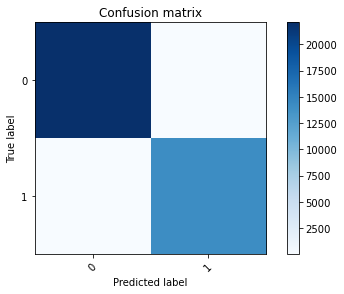

In [81]:
plot_confusion_matrix(cm, [0, 1])

In [82]:
plt.show()

In [83]:
print(metrics.classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22105
           1       1.00      1.00      1.00     14292

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



# Chris - Fully Connected Neural Network

In [138]:
# (Number of samples, sample size of rows, sample size of columns, number of channels per sample)
# (X, Y) size of record, so (1, 118 - 1) and we subtract 1 because of the target column
x_train_full = x_train
x_test_full = x_test

In [139]:
fc_model = Sequential()
fc_model.add(Dense(10, input_dim = x.shape[1], activation = 'relu'))
fc_model.add(Dense(15, activation = 'sigmoid'))
fc_model.add(Dense(y.shape[1], activation = 'softmax'))
fc_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

fc_model.fit(x_train_full,y_train, validation_data=(x_test_full,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=100)   

Epoch 1/100
3413/3413 - 2s - loss: 0.0499 - val_loss: 0.0140
Epoch 2/100
3413/3413 - 2s - loss: 0.0124 - val_loss: 0.0145
Epoch 3/100
3413/3413 - 2s - loss: 0.0104 - val_loss: 0.0099
Epoch 4/100
3413/3413 - 2s - loss: 0.0090 - val_loss: 0.0092
Epoch 5/100
3413/3413 - 2s - loss: 0.0079 - val_loss: 0.0087
Epoch 6/100
3413/3413 - 2s - loss: 0.0075 - val_loss: 0.0086
Epoch 7/100
3413/3413 - 2s - loss: 0.0069 - val_loss: 0.0079
Epoch 8/100
3413/3413 - 2s - loss: 0.0064 - val_loss: 0.0078
Epoch 9/100
3413/3413 - 2s - loss: 0.0060 - val_loss: 0.0074
Epoch 10/100
3413/3413 - 2s - loss: 0.0058 - val_loss: 0.0076
Epoch 11/100
3413/3413 - 2s - loss: 0.0055 - val_loss: 0.0078
Epoch 12/100
3413/3413 - 2s - loss: 0.0053 - val_loss: 0.0079
Epoch 13/100
3413/3413 - 2s - loss: 0.0051 - val_loss: 0.0072
Epoch 14/100
3413/3413 - 2s - loss: 0.0050 - val_loss: 0.0072
Epoch 00014: early stopping


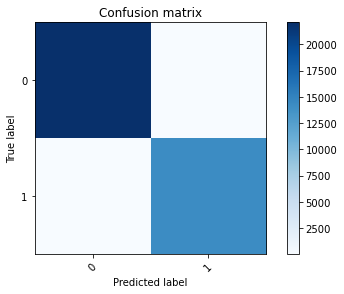

In [140]:
y_pred = fc_model.predict(x_test_full)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, [0, 1])
plt.show()

In [141]:
y_true = np.argmax(y_test,axis=1)

### Recall, Precision, and F1-score

In [142]:
print(metrics.classification_report(y_true, y_pred))

precision_score = metrics.precision_score(y_true, y_pred, average = "weighted")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22105
           1       1.00      1.00      1.00     14292

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



# Jarod - Testing CNN with different Hyperparameters

In [89]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

cnn_activation_results = []
cnn_layer_results = []
cnn_neuron_count_results = []
cnn_optimizer_results = []
cnn_kernel_results = []

In [90]:
def cnn_activation_testing(activation_0, activation_1, activation_2):
    # (Number of samples, sample size of rows, sample size of columns, number of channels per sample)
    # (X, Y) size of record, so (1, 118 - 1) and we subtract 1 because of the target column
    x_train_cnn = x_train.reshape(x_train.shape[0], 1, x.shape[1], 1)
    x_test_cnn = x_test.reshape(x_test.shape[0], 1, x.shape[1], 1)
    
    cnn_model = Sequential()
    
    # 32 is 32 neurons/filters/kernels.
    # more neurons = more features to extract from input data.
    # kernel_size is the dimensions of the data received for each neuron/filter/kernel.
    # strides is the specification of strides for convolution
    # padding "valid" = no padding, "same" = zero padding

    # Kernel_size set to (1, 1) because 1 is the number of outcomes available
    cnn_model.add(Conv2D(32, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                     activation=activation_0,
                     input_shape=(1, x.shape[1], 1)))

    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))

    cnn_model.add(Conv2D(64, kernel_size=(1, 1), strides=(1,1), activation=activation_1))

    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))

    cnn_model.add(Flatten())

    cnn_model.add(Dense(1024, activation=activation_2))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(y.shape[1], activation='softmax'))
    
    cnn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    cnn_model.fit(x_train_cnn, y_train, batch_size=32,
              validation_data=(x_test_cnn,y_test),
              callbacks=[monitor,checkpointer],
              verbose=2, epochs=100)
    cnn_model.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    pred = cnn_model.predict(x_test_cnn)
    pred = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    
    cnn_activation_results.append([y_true, pred])

In [91]:
def cnn_layer_testing(extra_layers):
    
    x_train_cnn = x_train.reshape(x_train.shape[0], 1, x.shape[1], 1)
    x_test_cnn = x_test.reshape(x_test.shape[0], 1, x.shape[1], 1)
    
    cnn_model = Sequential()
    
    cnn_model.add(Conv2D(32, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                     activation='relu',
                     input_shape=(1, x.shape[1], 1)))
    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
    # Adding more Conv2D layers and pooling layers for testing.
    for i in range(extra_layers):
        cnn_model.add(Conv2D(64, kernel_size=(1, 1), strides=(1,1), activation='relu'))
        cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
        
    cnn_model.add(Flatten())
    cnn_model.add(Dense(1024, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(y.shape[1], activation='softmax'))
    
    cnn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
    cnn_model.fit(x_train_cnn, y_train, batch_size=32,
              validation_data=(x_test_cnn,y_test),
              callbacks=[monitor,checkpointer],
              verbose=2, epochs=100)
    
    cnn_model.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    pred = cnn_model.predict(x_test_cnn)
    pred = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    
    cnn_layer_results.append([y_true, pred])

In [92]:
def cnn_neuron_count_testing(neuron_count):
    
    x_train_cnn = x_train.reshape(x_train.shape[0], 1, x.shape[1], 1)
    x_test_cnn = x_test.reshape(x_test.shape[0], 1, x.shape[1], 1)
    
    cnn_model = Sequential()
    
    cnn_model.add(Conv2D(32, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                     activation='relu',
                     input_shape=(1, x.shape[1], 1)))
    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
    cnn_model.add(Conv2D(64, kernel_size=(1, 1), strides=(1,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(neuron_count, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(y.shape[1], activation='softmax'))
    
    cnn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
    cnn_model.fit(x_train_cnn, y_train, batch_size=32,
              validation_data=(x_test_cnn,y_test),
              callbacks=[monitor,checkpointer],
              verbose=2, epochs=100)
    
    cnn_model.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    pred = cnn_model.predict(x_test_cnn)
    pred = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    
    cnn_neuron_count_results.append([y_true, pred])

In [93]:
def cnn_optimizer_testing(input_optimizer):
    
    x_train_cnn = x_train.reshape(x_train.shape[0], 1, x.shape[1], 1)
    x_test_cnn = x_test.reshape(x_test.shape[0], 1, x.shape[1], 1)
    
    cnn_model = Sequential()
    
    cnn_model.add(Conv2D(32, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                     activation='relu',
                     input_shape=(1, x.shape[1], 1)))
    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
    cnn_model.add(Conv2D(64, kernel_size=(1, 1), strides=(1,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(1024, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(y.shape[1], activation='softmax'))
    
    cnn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=input_optimizer, metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
    cnn_model.fit(x_train_cnn, y_train, batch_size=32,
              validation_data=(x_test_cnn,y_test),
              callbacks=[monitor,checkpointer],
              verbose=2, epochs=100)
    
    cnn_model.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    pred = cnn_model.predict(x_test_cnn)
    pred = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    
    cnn_optimizer_results.append([y_true, pred])

In [94]:
def cnn_kernel_testing(kernel_count, kernel_count_2, kernel_size):
    x_train_cnn = x_train.reshape(x_train.shape[0], 1, x.shape[1], 1)
    x_test_cnn = x_test.reshape(x_test.shape[0], 1, x.shape[1], 1)
    
    cnn_model = Sequential()
    
    cnn_model.add(Conv2D(kernel_count, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                     activation='relu',
                     input_shape=(1, x.shape[1], 1)))
    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
    cnn_model.add(Conv2D(kernel_count_2, kernel_size=(1, 1), strides=(1,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(1024, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(y.shape[1], activation='softmax'))
    
    cnn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
    cnn_model.fit(x_train_cnn, y_train, batch_size=32,
              validation_data=(x_test_cnn,y_test),
              callbacks=[monitor,checkpointer],
              verbose=2, epochs=100)
    
    cnn_model.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    pred = cnn_model.predict(x_test_cnn)
    pred = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    
    cnn_kernel_results.append([y_true, pred])

In [95]:
### Running CNN Activation Tests
cnn_activation_results = []
cnn_activation_testing('relu', 'tanh', 'sigmoid')
cnn_activation_testing('sigmoid', 'tanh', 'relu')
cnn_activation_testing('tanh', 'relu', 'sigmoid')
cnn_activation_testing('tanh', 'sigmoid', 'relu')

Epoch 1/100
3413/3413 - 32s - loss: 0.0290 - accuracy: 0.9905 - val_loss: 0.0163 - val_accuracy: 0.9943
Epoch 2/100
3413/3413 - 33s - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.0102 - val_accuracy: 0.9970
Epoch 3/100
3413/3413 - 33s - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.0086 - val_accuracy: 0.9973
Epoch 4/100
3413/3413 - 34s - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.0136 - val_accuracy: 0.9963
Epoch 5/100
3413/3413 - 33s - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.0080 - val_accuracy: 0.9976
Epoch 00005: early stopping
Epoch 1/100
3413/3413 - 36s - loss: 0.0418 - accuracy: 0.9857 - val_loss: 0.0268 - val_accuracy: 0.9893
Epoch 2/100
3413/3413 - 35s - loss: 0.0194 - accuracy: 0.9942 - val_loss: 0.0125 - val_accuracy: 0.9962
Epoch 3/100
3413/3413 - 32s - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.0130 - val_accuracy: 0.9968
Epoch 4/100
3413/3413 - 32s - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.0142 - val_accuracy: 0.9970
Epoch 00004: early stopping
Epoch 1/

In [96]:
### Running CNN Layer Tests
cnn_layer_results = []
cnn_layer_testing(1)
cnn_layer_testing(2)
cnn_layer_testing(3)

Epoch 1/100
3413/3413 - 31s - loss: 0.0285 - accuracy: 0.9927 - val_loss: 0.0156 - val_accuracy: 0.9955
Epoch 2/100
3413/3413 - 29s - loss: 0.0138 - accuracy: 0.9959 - val_loss: 0.0110 - val_accuracy: 0.9972
Epoch 3/100
3413/3413 - 29s - loss: 0.0118 - accuracy: 0.9966 - val_loss: 0.0122 - val_accuracy: 0.9977
Epoch 4/100
3413/3413 - 30s - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.0105 - val_accuracy: 0.9980
Epoch 00004: early stopping
Epoch 1/100
3413/3413 - 21s - loss: 0.0404 - accuracy: 0.9866 - val_loss: 0.0200 - val_accuracy: 0.9950
Epoch 2/100
3413/3413 - 20s - loss: 0.0184 - accuracy: 0.9945 - val_loss: 0.0147 - val_accuracy: 0.9965
Epoch 3/100
3413/3413 - 22s - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.0145 - val_accuracy: 0.9958
Epoch 4/100
3413/3413 - 23s - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0129 - val_accuracy: 0.9968
Epoch 5/100
3413/3413 - 23s - loss: 0.0120 - accuracy: 0.9963 - val_loss: 0.0117 - val_accuracy: 0.9966
Epoch 6/100
3413/3413 - 23s - loss: 

In [97]:
### Running CNN Neuron Count Tests
cnn_neuron_count_results = []
cnn_neuron_count_testing(256)
cnn_neuron_count_testing(512)
cnn_neuron_count_testing(1024)

Epoch 1/100
3413/3413 - 15s - loss: 0.0303 - accuracy: 0.9922 - val_loss: 0.0133 - val_accuracy: 0.9962
Epoch 2/100
3413/3413 - 13s - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0119 - val_accuracy: 0.9969
Epoch 3/100
3413/3413 - 14s - loss: 0.0129 - accuracy: 0.9964 - val_loss: 0.0131 - val_accuracy: 0.9973
Epoch 4/100
3413/3413 - 14s - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0.0106 - val_accuracy: 0.9977
Epoch 5/100
3413/3413 - 15s - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.0080 - val_accuracy: 0.9978
Epoch 6/100
3413/3413 - 13s - loss: 0.0098 - accuracy: 0.9973 - val_loss: 0.0078 - val_accuracy: 0.9979
Epoch 7/100
3413/3413 - 13s - loss: 0.0089 - accuracy: 0.9976 - val_loss: 0.0066 - val_accuracy: 0.9982
Epoch 8/100
3413/3413 - 13s - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0086 - val_accuracy: 0.9980
Epoch 9/100
3413/3413 - 13s - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.0085 - val_accuracy: 0.9979
Epoch 00009: early stopping
Epoch 1/100
3413/3413 - 21s - loss: 

In [98]:
### Running CNN Optimizer Tests
cnn_optimizer_results = []
cnn_optimizer_testing(Adam(lr=0.001, decay=1e-6))
cnn_optimizer_testing(SGD(lr=0.001, decay=1e-6))

Epoch 1/100
3413/3413 - 37s - loss: 0.0290 - accuracy: 0.9925 - val_loss: 0.0136 - val_accuracy: 0.9975
Epoch 2/100
3413/3413 - 31s - loss: 0.0139 - accuracy: 0.9961 - val_loss: 0.0139 - val_accuracy: 0.9967
Epoch 3/100
3413/3413 - 30s - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.0114 - val_accuracy: 0.9971
Epoch 4/100
3413/3413 - 35s - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0087 - val_accuracy: 0.9980
Epoch 5/100
3413/3413 - 30s - loss: 0.0094 - accuracy: 0.9972 - val_loss: 0.0093 - val_accuracy: 0.9979
Epoch 6/100
3413/3413 - 39s - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0078 - val_accuracy: 0.9980
Epoch 00006: early stopping
Epoch 1/100
3413/3413 - 30s - loss: 0.1949 - accuracy: 0.9480 - val_loss: 0.1044 - val_accuracy: 0.9751
Epoch 2/100
3413/3413 - 29s - loss: 0.0921 - accuracy: 0.9757 - val_loss: 0.0777 - val_accuracy: 0.9817
Epoch 3/100
3413/3413 - 29s - loss: 0.0746 - accuracy: 0.9806 - val_loss: 0.0660 - val_accuracy: 0.9834
Epoch 4/100
3413/3413 - 29s - loss: 

In [99]:
### Running Kernel Tests
cnn_kernel_results = []
cnn_kernel_testing(16, 32, (1,1))
cnn_kernel_testing(32, 64, (1,2))
cnn_kernel_testing(64, 128, (1,3))

Epoch 1/100
3413/3413 - 19s - loss: 0.0285 - accuracy: 0.9928 - val_loss: 0.0140 - val_accuracy: 0.9967
Epoch 2/100
3413/3413 - 19s - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.0111 - val_accuracy: 0.9970
Epoch 3/100
3413/3413 - 19s - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.0090 - val_accuracy: 0.9976
Epoch 4/100
3413/3413 - 19s - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.0102 - val_accuracy: 0.9976
Epoch 5/100
3413/3413 - 19s - loss: 0.0092 - accuracy: 0.9973 - val_loss: 0.0084 - val_accuracy: 0.9979
Epoch 00005: early stopping
Epoch 1/100
3413/3413 - 29s - loss: 0.0254 - accuracy: 0.9930 - val_loss: 0.0209 - val_accuracy: 0.9960
Epoch 2/100
3413/3413 - 30s - loss: 0.0138 - accuracy: 0.9963 - val_loss: 0.0158 - val_accuracy: 0.9967
Epoch 3/100
3413/3413 - 31s - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.0084 - val_accuracy: 0.9978
Epoch 4/100
3413/3413 - 31s - loss: 0.0106 - accuracy: 0.9972 - val_loss: 0.0107 - val_accuracy: 0.9976
Epoch 5/100
3413/3413 - 30s - loss: 

### Displaying Results

In [111]:
def printTestResults(results):
    for i in results:
        precision_score = metrics.precision_score(i[0], i[1], average = 'weighted')
        print('Precision score: {}'.format(precision_score))
        recall_score = metrics.recall_score(i[0], i[1], average = 'weighted')
        print('Recall score: {}'.format(recall_score))
        f1_score = metrics.f1_score(i[0], i[1], average = 'weighted')
        print('F1 score: {}'.format(f1_score))
        print()

In [112]:
printTestResults(cnn_activation_results)

Precision score: 0.9976097959452684
Recall score: 0.9976096931065748
F1 score: 0.997609737423164

Precision score: 0.9961809582753399
Recall score: 0.9961810039288952
F1 score: 0.9961809803140844

Precision score: 0.9982144650467827
Recall score: 0.9982141385279006
F1 score: 0.9982138837567627

Precision score: 0.9980496722872001
Recall score: 0.99804928977663
F1 score: 0.9980489872044462



In [113]:
printTestResults(cnn_layer_results)

Precision score: 0.9979680041502645
Recall score: 0.9979668654009946
F1 score: 0.9979664105875882

Precision score: 0.9975547375748275
Recall score: 0.9975547435228178
F1 score: 0.9975544555116362

Precision score: 0.9974475964005767
Recall score: 0.997444844355304
F1 score: 0.9974440008470589



In [114]:
printTestResults(cnn_neuron_count_results)

Precision score: 0.9982423809836538
Recall score: 0.9982416133197791
F1 score: 0.9982412858013203

Precision score: 0.9982426980912009
Recall score: 0.9982416133197791
F1 score: 0.9982412419244319

Precision score: 0.9980245363153387
Recall score: 0.9980218149847515
F1 score: 0.9980211991685348



In [115]:
printTestResults(cnn_optimizer_results)

Precision score: 0.9980494785601047
Recall score: 0.99804928977663
F1 score: 0.9980490357583074

Precision score: 0.994009668524163
Recall score: 0.9940104953704976
F1 score: 0.9940098271282929



In [116]:
printTestResults(cnn_kernel_results)

Precision score: 0.997914065481997
Recall score: 0.9979119158172377
F1 score: 0.9979113181252527

Precision score: 0.997802037968931
Recall score: 0.9978020166497239
F1 score: 0.9978017714232267

Precision score: 0.997695174282757
Recall score: 0.9976921174822101
F1 score: 0.9976913411203739



# Chris - Testing FC with different Hyperparameters

### Defining Tests for FC Model

In [123]:
fc_activation_results = []
fc_layer_results = []
fc_neuron_results = []
fc_optimizer_results = []

In [124]:
def fc_activation_testing(activation_0, activation_1):
    fc_model = Sequential()
    fc_model.add(Dense(10, input_dim = x.shape[1], activation = activation_0))
    fc_model.add(Dense(15, activation = activation_1))
    fc_model.add(Dense(y.shape[1], activation = 'softmax'))
    fc_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    fc_model.fit(x_train_full,y_train, validation_data=(x_test_full,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=100)  

    y_pred = fc_model.predict(x_test_full)
    y_pred = np.argmax(y_pred, axis = 1)
    y_true = np.argmax(y_test,axis=1)
    
    fc_activation_results.append([y_true, y_pred])

In [125]:
def fc_layer_testing(extra_layers):
    fc_model = Sequential()
    fc_model.add(Dense(10, input_dim = x.shape[1], activation = 'relu'))
    
    for i in range(extra_layers):
        fc_model.add(Dense(15, activation = 'sigmoid'))
        
    fc_model.add(Dense(y.shape[1], activation = 'softmax'))
    fc_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    fc_model.fit(x_train_full,y_train, validation_data=(x_test_full,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=100)  

    y_pred = fc_model.predict(x_test_full)
    y_pred = np.argmax(y_pred, axis = 1)
    y_true = np.argmax(y_test,axis=1)
    
    fc_layer_results.append([y_true, y_pred])

In [126]:
def fc_neuron_testing(neuron_count1, neuron_count2):
    fc_model = Sequential()
    fc_model.add(Dense(neuron_count1, input_dim = x.shape[1], activation = 'relu'))
    fc_model.add(Dense(neuron_count2, activation = 'sigmoid'))
    fc_model.add(Dense(y.shape[1], activation = 'softmax'))
    fc_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    fc_model.fit(x_train_full,y_train, validation_data=(x_test_full,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=100)  

    y_pred = fc_model.predict(x_test_full)
    y_pred = np.argmax(y_pred, axis = 1)
    y_true = np.argmax(y_test,axis=1)

    fc_neuron_results.append([y_true, y_pred])

In [132]:
def fc_optimizer_testing(input_optimizer):
    fc_model = Sequential()
    fc_model.add(Dense(10, input_dim = x.shape[1], activation = 'relu'))
    fc_model.add(Dense(15, activation = 'sigmoid'))
    fc_model.add(Dense(y.shape[1], activation = 'softmax'))
    fc_model.compile(loss = 'categorical_crossentropy', optimizer = input_optimizer)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    fc_model.fit(x_train_full,y_train, validation_data=(x_test_full,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=100)  

    y_pred = fc_model.predict(x_test_full)
    y_pred = np.argmax(y_pred, axis = 1)
    y_true = np.argmax(y_test,axis=1)
    
    fc_optimizer_results.append([y_true, y_pred])

### Running Tests for FC Model

In [128]:
fc_activation_results = []
fc_activation_testing('relu', 'sigmoid')
fc_activation_testing('relu', 'tanh')
fc_activation_testing('sigmoid', 'relu')
fc_activation_testing('sigmoid', 'tanh')
fc_activation_testing('tanh', 'relu')
fc_activation_testing('tanh', 'sigmoid')

Epoch 1/100
3413/3413 - 2s - loss: 0.0489 - val_loss: 0.0147
Epoch 2/100
3413/3413 - 2s - loss: 0.0117 - val_loss: 0.0101
Epoch 3/100
3413/3413 - 2s - loss: 0.0088 - val_loss: 0.0088
Epoch 4/100
3413/3413 - 2s - loss: 0.0081 - val_loss: 0.0080
Epoch 5/100
3413/3413 - 2s - loss: 0.0075 - val_loss: 0.0076
Epoch 6/100
3413/3413 - 2s - loss: 0.0071 - val_loss: 0.0076
Epoch 7/100
3413/3413 - 2s - loss: 0.0068 - val_loss: 0.0071
Epoch 8/100
3413/3413 - 2s - loss: 0.0065 - val_loss: 0.0073
Epoch 9/100
3413/3413 - 2s - loss: 0.0063 - val_loss: 0.0071
Epoch 10/100
3413/3413 - 2s - loss: 0.0061 - val_loss: 0.0078
Epoch 00010: early stopping
Epoch 1/100
3413/3413 - 2s - loss: 0.0280 - val_loss: 0.0100
Epoch 2/100
3413/3413 - 2s - loss: 0.0092 - val_loss: 0.0093
Epoch 3/100
3413/3413 - 2s - loss: 0.0075 - val_loss: 0.0076
Epoch 4/100
3413/3413 - 2s - loss: 0.0068 - val_loss: 0.0070
Epoch 5/100
3413/3413 - 2s - loss: 0.0060 - val_loss: 0.0068
Epoch 6/100
3413/3413 - 2s - loss: 0.0057 - val_loss: 0.

In [129]:
fc_layer_results = []
fc_layer_testing(0) #1 hidden layer
fc_layer_testing(1) #2 hidden layers
fc_layer_testing(2) #3 hidden layers
fc_layer_testing(4) #4 hidden layers

Epoch 1/100
3413/3413 - 2s - loss: 0.0445 - val_loss: 0.0152
Epoch 2/100
3413/3413 - 2s - loss: 0.0128 - val_loss: 0.0108
Epoch 3/100
3413/3413 - 2s - loss: 0.0101 - val_loss: 0.0106
Epoch 4/100
3413/3413 - 2s - loss: 0.0085 - val_loss: 0.0098
Epoch 5/100
3413/3413 - 2s - loss: 0.0080 - val_loss: 0.0095
Epoch 6/100
3413/3413 - 2s - loss: 0.0076 - val_loss: 0.0092
Epoch 7/100
3413/3413 - 2s - loss: 0.0069 - val_loss: 0.0094
Epoch 8/100
3413/3413 - 2s - loss: 0.0068 - val_loss: 0.0094
Epoch 9/100
3413/3413 - 2s - loss: 0.0062 - val_loss: 0.0100
Epoch 00009: early stopping
Epoch 1/100
3413/3413 - 2s - loss: 0.0487 - val_loss: 0.0128
Epoch 2/100
3413/3413 - 2s - loss: 0.0114 - val_loss: 0.0101
Epoch 3/100
3413/3413 - 2s - loss: 0.0092 - val_loss: 0.0090
Epoch 4/100
3413/3413 - 2s - loss: 0.0083 - val_loss: 0.0093
Epoch 5/100
3413/3413 - 2s - loss: 0.0077 - val_loss: 0.0079
Epoch 6/100
3413/3413 - 2s - loss: 0.0071 - val_loss: 0.0084
Epoch 7/100
3413/3413 - 2s - loss: 0.0068 - val_loss: 0.0

In [130]:
fc_neuron_results = []
fc_neuron_testing(10, 20)
fc_neuron_testing(30, 60)
fc_neuron_testing(70, 140)
fc_neuron_testing(150, 300)

Epoch 1/100
3413/3413 - 2s - loss: 0.0486 - val_loss: 0.0117
Epoch 2/100
3413/3413 - 2s - loss: 0.0108 - val_loss: 0.0103
Epoch 3/100
3413/3413 - 2s - loss: 0.0093 - val_loss: 0.0089
Epoch 4/100
3413/3413 - 2s - loss: 0.0080 - val_loss: 0.0079
Epoch 5/100
3413/3413 - 2s - loss: 0.0073 - val_loss: 0.0077
Epoch 6/100
3413/3413 - 2s - loss: 0.0067 - val_loss: 0.0073
Epoch 7/100
3413/3413 - 2s - loss: 0.0062 - val_loss: 0.0074
Epoch 8/100
3413/3413 - 2s - loss: 0.0059 - val_loss: 0.0073
Epoch 9/100
3413/3413 - 2s - loss: 0.0056 - val_loss: 0.0077
Epoch 10/100
3413/3413 - 2s - loss: 0.0054 - val_loss: 0.0078
Epoch 00010: early stopping
Epoch 1/100
3413/3413 - 2s - loss: 0.0266 - val_loss: 0.0102
Epoch 2/100
3413/3413 - 2s - loss: 0.0083 - val_loss: 0.0082
Epoch 3/100
3413/3413 - 2s - loss: 0.0070 - val_loss: 0.0077
Epoch 4/100
3413/3413 - 2s - loss: 0.0063 - val_loss: 0.0072
Epoch 5/100
3413/3413 - 2s - loss: 0.0057 - val_loss: 0.0096
Epoch 6/100
3413/3413 - 2s - loss: 0.0053 - val_loss: 0.

In [133]:
fc_optimizer_results = []
fc_optimizer_testing('adam')
fc_optimizer_testing('sgd')

Epoch 1/100
3413/3413 - 2s - loss: 0.0481 - val_loss: 0.0118
Epoch 2/100
3413/3413 - 2s - loss: 0.0102 - val_loss: 0.0090
Epoch 3/100
3413/3413 - 2s - loss: 0.0083 - val_loss: 0.0084
Epoch 4/100
3413/3413 - 2s - loss: 0.0075 - val_loss: 0.0080
Epoch 5/100
3413/3413 - 2s - loss: 0.0069 - val_loss: 0.0084
Epoch 6/100
3413/3413 - 2s - loss: 0.0065 - val_loss: 0.0081
Epoch 7/100
3413/3413 - 2s - loss: 0.0062 - val_loss: 0.0073
Epoch 8/100
3413/3413 - 2s - loss: 0.0060 - val_loss: 0.0064
Epoch 9/100
3413/3413 - 2s - loss: 0.0059 - val_loss: 0.0076
Epoch 10/100
3413/3413 - 2s - loss: 0.0056 - val_loss: 0.0067
Epoch 11/100
3413/3413 - 2s - loss: 0.0055 - val_loss: 0.0074
Epoch 12/100
3413/3413 - 2s - loss: 0.0054 - val_loss: 0.0066
Epoch 13/100
3413/3413 - 2s - loss: 0.0053 - val_loss: 0.0065
Epoch 00013: early stopping
Epoch 1/100
3413/3413 - 1s - loss: 0.1606 - val_loss: 0.0676
Epoch 2/100
3413/3413 - 1s - loss: 0.0573 - val_loss: 0.0516
Epoch 3/100
3413/3413 - 1s - loss: 0.0445 - val_loss:

### Displaying Results for FC Model

In [134]:
printTestResults(fc_activation_results)

Precision score: 0.997940809619639
Recall score: 0.9979393906091162
F1 score: 0.9979396826839481

Precision score: 0.998159999273554
Recall score: 0.9981591889441438
F1 score: 0.9981588345946535

Precision score: 0.9981600312511533
Recall score: 0.9981591889441438
F1 score: 0.9981593819610114

Precision score: 0.9979414379692578
Recall score: 0.9979393906091162
F1 score: 0.9979388136844379

Precision score: 0.9984889067094139
Recall score: 0.9984888864466852
F1 score: 0.9984888957880524

Precision score: 0.9985163154539259
Recall score: 0.9985163612385636
F1 score: 0.9985162877736604



In [135]:
printTestResults(fc_layer_results)

Precision score: 0.9980224661845992
Recall score: 0.9980218149847515
F1 score: 0.9980219858741957

Precision score: 0.9984338929644848
Recall score: 0.9984339368629283
F1 score: 0.9984339078034596

Precision score: 0.9980500576120477
Recall score: 0.99804928977663
F1 score: 0.9980489142719461

Precision score: 0.9982148243400792
Recall score: 0.9982141385279006
F1 score: 0.9982143037995159



In [136]:
printTestResults(fc_neuron_results)

Precision score: 0.9977760637562496
Recall score: 0.9977745418578454
F1 score: 0.9977739744811719

Precision score: 0.9985437854459002
Recall score: 0.9985438360304421
F1 score: 0.9985437909841247

Precision score: 0.9982692345391228
Recall score: 0.9982690881116576
F1 score: 0.9982691415821779

Precision score: 0.9987914418883471
Recall score: 0.9987911091573481
F1 score: 0.9987909592547204



In [137]:
printTestResults(fc_optimizer_results)

Precision score: 0.9985442569217429
Recall score: 0.9985438360304421
F1 score: 0.9985436282939759

Precision score: 0.9977194720643849
Recall score: 0.9977195922740886
F1 score: 0.9977194934844517

